### Introduction
Goal here is to use an XGBoost classifier to predict wildfire ignition from weather variables. Three anticipated issues are:

1. Large dataset size - current working dataset has 7.3 million observations of 25 variables and this is likely to grow as the project progresses
2. Highly imbalanced data (~20 times more observations without fire than with)
3. Overlapping classes - just because the right conditions for ignition exist does not guarantee a fire.

We can hopefully deal with 1 and 2 fairly easily. The third is a deeper question/problem that will need some additional thought and likely a switch from binary classification to ignition probabilities and regression.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from time import time
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from xgboost import XGBClassifier
from IPython.display import display_markdown
from scipy.interpolate import griddata

%matplotlib inline
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.despine()

<Figure size 432x288 with 0 Axes>

**Variable definitions**

In [2]:
data_file = '../data/training_data/1992-1997_training_data.csv'
rand_seed = 123
data_sample_fraction = 0.001
test_train_split_ratio = 0.3
xgb_jobs = 5
optimization_jobs = 3
search_iterations = 100
search_scoring_func = make_scorer(average_precision_score)

**Functions**

In [3]:
def random_sample(data, fraction):
    n = len(data)
    k = int(len(data) * fraction)
    
    indices = random.sample(range(0, n), k)
    
    return data.iloc[indices]

def print_model_score(model, x_train, y_train, x_test, y_test):
    training_score = average_precision_score(model.predict(x_train), y_train)
    test_score = average_precision_score(model.predict(x_test), y_test)
    
    #print('Average precision-recall score, training set: {}'.format(np.round(training_score, 2)))
    #print('<b>Average precision-recall score, test set: {}</b>'.format(np.round(test_score,2)))
    
    display_markdown('**Average precision-recall score, training set: {}**'.format(np.round(training_score, 2)), raw=True)
    display_markdown('**Average precision-recall score, test set: {}**'.format(np.round(test_score, 2)), raw=True)

    
def display_confusion_matrix(model, class_names, x_test, y_test):

    raw_cm = confusion_matrix(y_test, model.predict(x_test))
    print("Raw count confusion matrix")
    print(raw_cm)
    
    normalized_cm = plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

    normalized_cm.ax_.set_title("Normalized confusion matrix")

    plt.show()
    
def stratified_train_test_split(data, targets, rand_seed):
    sss = StratifiedShuffleSplit(
        n_splits=1,
        test_size=test_train_split_ratio, 
        random_state=rand_seed
    )

    for train_index, test_index in sss.split(data, targets):
        x_train, x_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = targets.iloc[train_index], targets.iloc[test_index]
        
        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

def tune_hyperparameters(
    known_params,
    param_dist, 
    x_train, 
    y_train, 
    num_jobs, 
    search_iterations, 
    search_scoring_func
):

    # initalize XGBoost classifier
    xgb_mod = XGBClassifier(**known_params)

    # set up random search
    xgb_random_search = RandomizedSearchCV(
        xgb_mod, 
        param_distributions=param_dist,
        scoring=search_scoring_func,
        n_iter=search_iterations,
        n_jobs=num_jobs
    )

    # run and time search
    start = time()
    xgb_best_model = xgb_random_search.fit(x_train, y_train)
    print("RandomizedSearchCV took %.f min. for %d candidate"
          " parameter settings." % (((time() - start)/60), search_iterations))
    
    return xgb_best_model, xgb_random_search

def regularize_grid(x, y, z, resolution):

    # target grid to interpolate to
    xi = np.arange(min(x), max(x), ((max(x) - min(x)) / resolution))
    yi = np.arange(min(y), max(y), ((max(y) - min(y)) / resolution))
    xi, yi = np.meshgrid(xi, yi)

    # interpolate
    zi = griddata((x, y), z, (xi, yi), method='linear')
    
    return xi, yi, zi

In [4]:
# read data
data = pd.read_csv(data_file, low_memory=False)

# set ignition to 0 for noxels with no fire
data['ignition'].fillna(0, inplace=True)

# count number of observations in each class
ignition_count = len(data[data["ignition"] == 1])
no_ignition_count = len(data) - ignition_count
print('Total observations: {:.1E}'.format(len(data)))
print('Ignitions count: {:.1E}'.format(ignition_count))
print('Non ignitions count: {:.1E}'.format(no_ignition_count))

Total observations: 7.3E+06
Ignitions count: 3.7E+05
Non ignitions count: 6.9E+06


OK, so before we dig into this much farther, I am noticing an issue. For some fires we know the discovery time and some we do not. I can imagine a few ways of dealing with this.

1. Throw out fires for which we do not know the discovery time
2. Average everything at the day resolution level

I am leaning toward option two because:

1. Discovery time is not ignition time so the weather state during that exact hour may not be pertinent anyway - what if the fire had already been burning for hours and the temperature had changed drastically?
2. The data is already skewed toward no ignition observations, I would rather not have to throw out even more fires. Also, doing so will mean that I have observations where there was a fire which was not included in the dataset. This will only exacerbate problem 3 above.

Specific plan is actually to roll a moving average across the data, including ignition value.

In [5]:
# roll data with 24 hr windowed mean
data_moving_avg = data.groupby(['lat', 'lon']).rolling(24, on="weather_bin_time").mean()
data_moving_avg.reset_index(drop=True, inplace=True)

# clean up dataframe
data_moving_avg['weather_bin_time'] = pd.to_datetime(data_moving_avg['weather_bin_time'])
data_moving_avg['weather_bin_month'] = data_moving_avg['weather_bin_time'].dt.month
data_moving_avg['weather_bin_year'] = data_moving_avg['weather_bin_time'].dt.year
data_moving_avg.drop(['fire_discovery_time', 'size', 'size_class', 'weather_bin_time'], axis=1, inplace=True)
data_moving_avg.dropna(inplace=True)

In [6]:
ignitions = data_moving_avg[data_moving_avg['ignition'] > 0]
ignitions = ignitions.assign(ignition=1)
no_ignitions = data_moving_avg[data_moving_avg['ignition'] == 0]

print('Total observations: {:.1E}'.format(len(data_moving_avg)))
print('Ignitions count: {:.1E}'.format(len(ignitions)))
print('Non ignitions count: {:.1E}'.format(len(no_ignitions)))

Total observations: 7.3E+06
Ignitions count: 9.1E+05
Non ignitions count: 6.4E+06


OK, now we need to randomly sample the positive and negative datasets, preserving the sample size ratio.

In [7]:
no_ignitions_sample = random_sample(no_ignitions, data_sample_fraction)
ignitions_sample = random_sample(ignitions, data_sample_fraction)

sampled_data = no_ignitions_sample.append(ignitions_sample)

**Game on!** Let's keep track of our results as we begin to play with the data:

In [ ]:
results = pd.DataFrame(columns=['Model description', 'Precision recall score', 'False negative rate','False '])

### Baseline XGBoost model

XGBClassifier training took 0.0 min.


**Average precision-recall score, training set: 0.24**

**Average precision-recall score, test set: 0.1**

Raw count confusion matrix
[[1576   14]
 [ 196   31]]


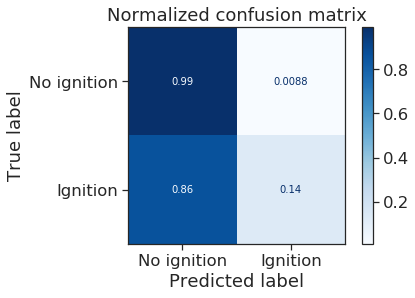

In [8]:
# make training and test data from sampled fire weather data
class_names = np.array(['No ignition', 'Ignition'])
unbalanced_targets = sampled_data['ignition']
unbalanced_data = sampled_data.drop(['ignition'], axis=1)
x_train_unbalanced, x_test_unbalanced, y_train_unbalanced, y_test_unbalanced = train_test_split(unbalanced_data.values, unbalanced_targets.values, random_state=rand_seed)

# instantiate and train classifier with defaults
default_xgb_model = XGBClassifier(
    n_jobs=(xgb_jobs * optimization_jobs), # use everything we've got! 
    random_state=rand_seed
)

start = time()
default_xgb_model.fit(x_train_unbalanced, y_train_unbalanced)
print('XGBClassifier training took {} min.'.format(np.round((time() - start)/60), 2))
    
# score and show confusion matrix
print_model_score(default_xgb_model, x_train_unbalanced, y_train_unbalanced, x_test_unbalanced, y_test_unbalanced)
display_confusion_matrix(default_xgb_model, class_names, x_test_unbalanced, y_test_unbalanced)

OK, not good - we missed 78% of fires. Next let's do two things:

1. Stratify the train-test-split so that the training and test sets have the same ratio of ignition to no ignition as the whole dataset
2. Try to alleviate the problems caused by imbalanced classes with XGBClassifier's class weight parameter

### Train-test-split stratification and class weighting

In [9]:
x_train_stratified, y_train_stratified, x_test_stratified, y_test_stratified = stratified_train_test_split(unbalanced_data, unbalanced_targets, rand_seed)

Class weight: 18.66

XGBClassifier training took 0.0 min.


**Average precision-recall score, training set: 0.59**

**Average precision-recall score, test set: 0.55**

Raw count confusion matrix
[[1264  644]
 [  22  250]]


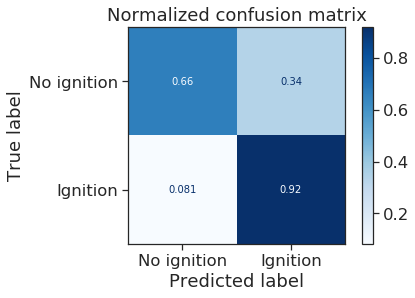

In [10]:
class_weight = no_ignition_count / ignition_count
print('Class weight: {}\n'.format(np.round(class_weight,2)))

# instantiate classifier with class weight
weighted_xgb_model = XGBClassifier(
    n_jobs=(xgb_jobs * optimization_jobs), # use everything we've got! 
    random_state=rand_seed,
    scale_pos_weight=class_weight
)
# train on stratified data
start = time()
weighted_xgb_model.fit(x_train_stratified, y_train_stratified)
print('XGBClassifier training took {} min.'.format(np.round((time() - start)/60), 2))

# score and show confusion matrix
print_model_score(weighted_xgb_model, x_train_stratified, y_train_stratified, x_test_stratified, y_test_stratified)
display_confusion_matrix(weighted_xgb_model, class_names, x_test_stratified, y_test_stratified)

Better, due to the nature of the problem, the false negative rate is most important but I would also like to see false positives decrease as well.

### Class weight optimization

In [11]:
known_params = {
    'n_jobs': xgb_jobs, 
    'random_state': rand_seed
}

param_dist = {
    'scale_pos_weight': np.arange(0.0, 1000, 0.1)
}

optimized_class_weight_model, xgb_random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train_stratified, 
    y_train_stratified, 
    optimization_jobs, 
    search_iterations, 
    search_scoring_func
)

RandomizedSearchCV took 1 min. for 100 candidate parameter settings.


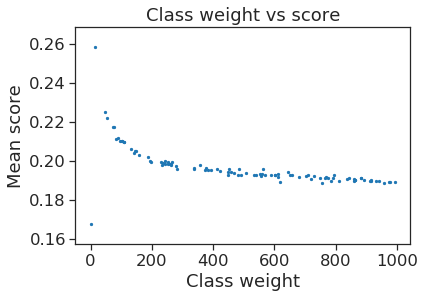

In [12]:
class_weight_optimization_results = pd.DataFrame(xgb_random_search.cv_results_).dropna()

plt.scatter(class_weight_optimization_results.param_scale_pos_weight, class_weight_optimization_results.mean_test_score, s=5)
plt.xlabel("Class weight")
plt.ylabel("Mean score")
plt.title("Class weight vs score")
plt.show()

**Average precision-recall score, training set: 0.58**

**Average precision-recall score, test set: 0.54**

Raw count confusion matrix
[[1280  628]
 [  27  245]]


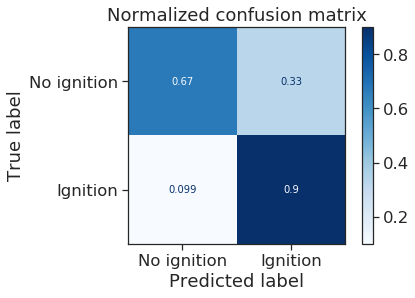

In [13]:
# score the best model and show confusion matrix
print_model_score(optimized_class_weight_model, x_train_stratified, y_train_stratified, x_test_stratified, y_test_stratified)
display_confusion_matrix(optimized_class_weight_model, class_names, x_test_stratified, y_test_stratified)

Strange, attempting to optimize the class weight definitely did not help. In fact - it made things worse. Not quite sure how that is possible? Must be overfitting. The only way I can interpret this result is as follows: optimizing the class weight for best possible precision-recall score on the training set causes a decrease in model performance on the test set.

What's next? My thought here is - we have this giant data set and we are only sampling it at 1-10%. We can easily get matched N samples from both classes and still leave 30% hidden for testing.

### Matched samples

In [14]:
def k_random_sample(data, k):
    n = len(data)
    
    indices = random.sample(range(0, n), k)
    
    return data.iloc[indices]

k = 1000

no_ignitions_sample = k_random_sample(no_ignitions, k)
ignitions_sample = k_random_sample(ignitions, k)

sampled_data = no_ignitions_sample.append(ignitions_sample)

XGBClassifier training took 0.0 min.


**Average precision-recall score, training set: 0.83**

**Average precision-recall score, test set: 0.76**

Raw count confusion matrix
[[180  74]
 [ 41 205]]


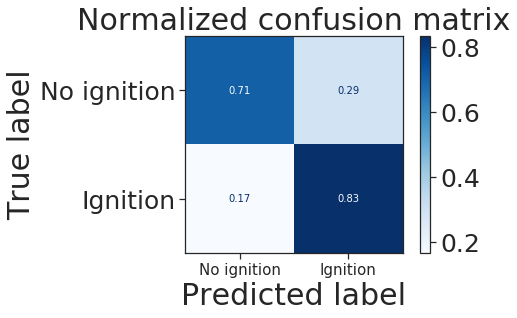

In [34]:
# make training and test data from sampled fire weather data
class_names = np.array(['No ignition', 'Ignition'])
balanced_targets = sampled_data['ignition']
balanced_data = sampled_data.drop(['ignition'], axis=1)
x_train_balanced, x_test_balanced, y_train_balanced, y_test_balanced = train_test_split(balanced_data.values, balanced_targets.values, random_state=rand_seed)

# instantiate and train classifier with defaults
default_xgb_model = XGBClassifier(
    n_jobs=(xgb_jobs * optimization_jobs), # use everything we've got! 
    random_state=rand_seed
)

start = time()
default_xgb_model.fit(x_train_unbalanced, y_train_unbalanced)
print('XGBClassifier training took {} min.'.format(np.round((time() - start)/60), 2))
    
# score and show confusion matrix
print_model_score(default_xgb_model, x_train_unbalanced, y_train_unbalanced, x_test_unbalanced, y_test_unbalanced)
display_confusion_matrix(default_xgb_model, class_names, x_test_unbalanced, y_test_unbalanced)

### Matched samples, optimize class weight?

In [16]:
known_params = {
    'n_jobs': xgb_jobs, 
    'random_state': rand_seed
}

param_dist = {
    'scale_pos_weight': np.arange(0.0, 1000, 0.1)
}

optimized_class_weight_model, xgb_random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train_stratified, 
    y_train_stratified, 
    optimization_jobs, 
    search_iterations, 
    search_scoring_func
)

RandomizedSearchCV took 1 min. for 100 candidate parameter settings.


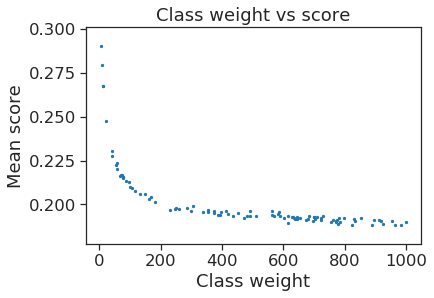

In [17]:
class_weight_optimization_results = pd.DataFrame(xgb_random_search.cv_results_).dropna()

plt.scatter(class_weight_optimization_results.param_scale_pos_weight, class_weight_optimization_results.mean_test_score, s=5)
plt.xlabel("Class weight")
plt.ylabel("Mean score")
plt.title("Class weight vs score")
plt.show()

**Average precision-recall score, training set: 0.69**

**Average precision-recall score, test set: 0.69**

Raw count confusion matrix
[[196  58]
 [ 61 185]]


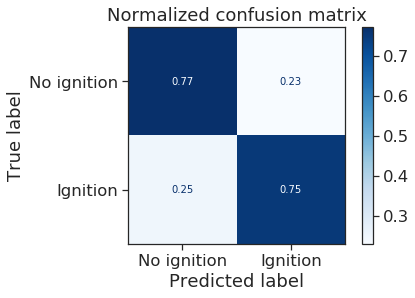

In [18]:
# score and show confusion matrix
print_model_score(optimized_class_weight_model, x_train_unbalanced, y_train_unbalanced, x_test_unbalanced, y_test_unbalanced)
display_confusion_matrix(optimized_class_weight_model, class_names, x_test_unbalanced, y_test_unbalanced)

Nope, for whatever reason optimizing class weight on this dataset is nonproductive. OK, let's play with n_estimators and learning rate using the N matched dataset and no class weight.

### Hyperprameter tuning

**Learning rate and estimator count**

In [20]:
known_params = {
    'random_state': rand_seed,
    'n_jobs': xgb_jobs
}

param_dist = {
    'learning_rate': loguniform(0.001, 1),
    'n_estimators': range(1,10000)
}

xgb_best_model, xgb_random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train_stratified, 
    y_train_stratified, 
    optimization_jobs, 
    search_iterations, 
    search_scoring_func
)

RandomizedSearchCV took 27 min. for 100 candidate parameter settings.


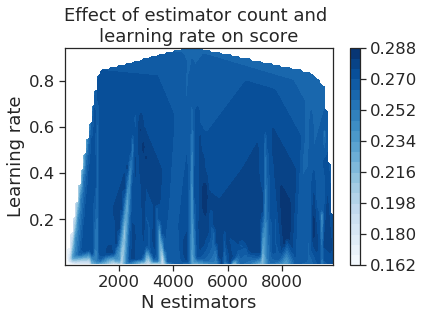

In [21]:
rand_search_results = pd.DataFrame(xgb_random_search.cv_results_).dropna()

x = rand_search_results['param_n_estimators']
y = rand_search_results['param_learning_rate']
z = rand_search_results['mean_test_score']
xi, yi, zi = regularize_grid(x, y, z, 100)

plt.contourf(xi, yi, zi, 20, cmap=plt.cm.Blues)
plt.xlabel("N estimators")
plt.ylabel("Learning rate")
plt.title("Effect of estimator count and \nlearning rate on score")
plt.colorbar()
plt.show()

**Average precision-recall score, training set: 0.69**

**Average precision-recall score, test set: 0.69**

Raw count confusion matrix
[[196  58]
 [ 61 185]]


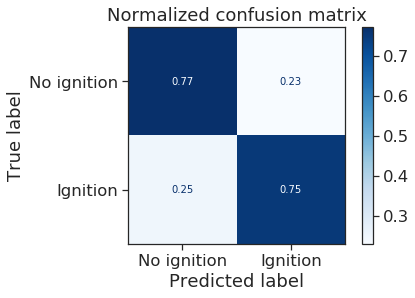

In [22]:
# score and show confusion matrix
print_model_score(optimized_class_weight_model, x_train_unbalanced, y_train_unbalanced, x_test_unbalanced, y_test_unbalanced)
display_confusion_matrix(optimized_class_weight_model, class_names, x_test_unbalanced, y_test_unbalanced)

In [25]:
xgb_model = XGBClassifier(
    n_jobs=(xgb_jobs * optimization_jobs), # use everything we've got! 
    random_state=rand_seed
)

xgb_model.fit(x_train_stratified, y_train_stratified)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=15,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

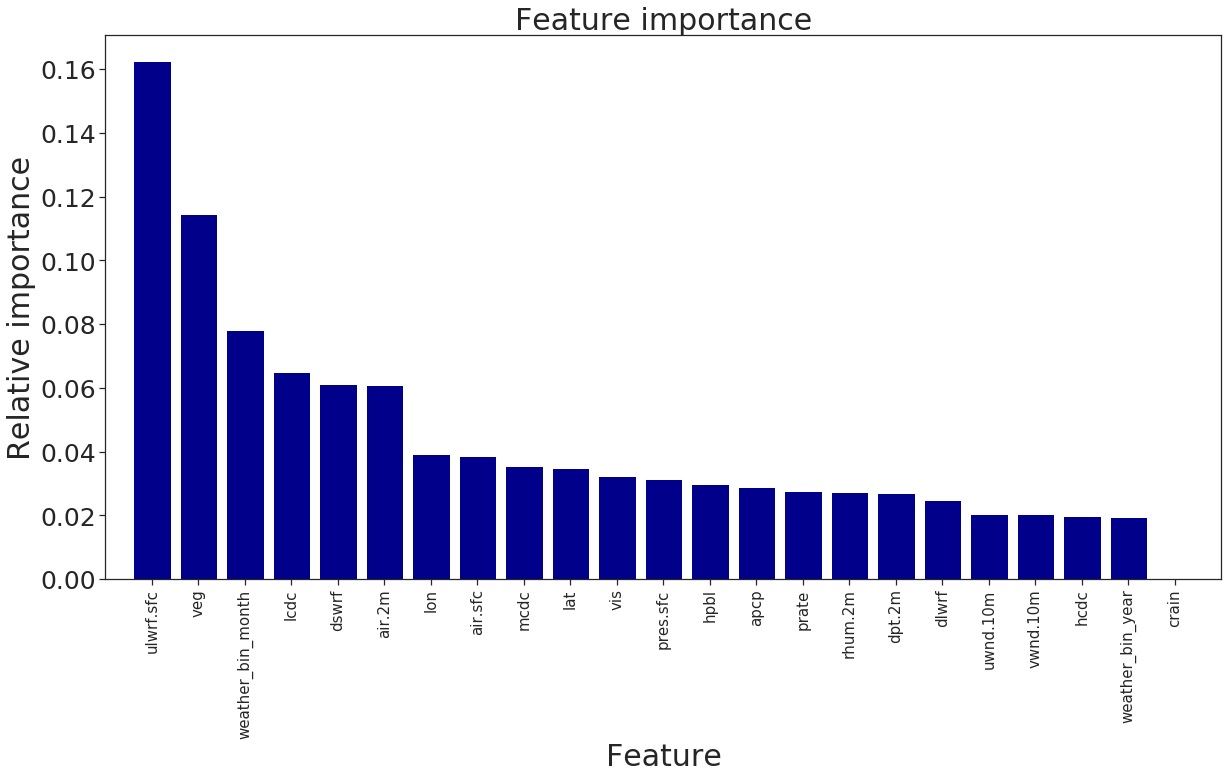

In [26]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(list(unbalanced_data))

plt.figure(figsize=(20,10))
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.title("Feature importance")
plt.bar(range(x_test_unbalanced.shape[1]), importances[indices],
       color="darkblue", align="center")
plt.xticks(np.arange(len(indices)), feature_names[indices], rotation='vertical')
plt.xlim([-1, x_test_unbalanced.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Relative importance")
plt.show()

In [30]:
top_n_features

array(['ulwrf.sfc'], dtype='<U17')

In [36]:
x_train_

,ulwrf.sfc
6240915,319.354167
4873897,340.697917
1558111,348.572917
5547084,471.984375
6306378,391.127604
...,...
3831770,502.695312
2519772,485.500000
5758109,379.179688
7249144,406.424479


In [41]:
train_scores = list()
test_scores = list()

for n in range(1,(len(feature_names) + 1)):
    # grab top n feature names
    top_n_features = feature_names[indices[0:n]]

    # rebuild training and test sets with feature subset
    balanced_data_subset = balanced_data[top_n_features]
    x_train_balanced_subset, y_train_balanced_subset, x_test_balanced_subset, y_test_balanced_subset = stratified_train_test_split(balanced_data_subset, balanced_targets, rand_seed)

    # instantiate and train classifier
    xgb_mod = XGBClassifier(
        n_jobs=(xgb_jobs * optimization_jobs), # use everything we've got! 
        random_state=rand_seed
    )

    xgb_mod.fit(x_train_balanced_subset, y_train_balanced_subset)

    # report score for feature subset
    training_score = average_precision_score(xgb_mod.predict(x_train_balanced_subset), y_train_balanced_subset)
    test_score = average_precision_score(xgb_mod.predict(x_test_balanced_subset), y_test_balanced_subset)
    
    train_scores.append(training_score)
    test_scores.append(test_score)
    
    print('Top {} features, precision-recall score train/test: {}/{}'.format(n,np.round(training_score,2),np.round(test_score,2)))

Top 1 features, precision-recall score train/test: 0.71/0.7
Top 2 features, precision-recall score train/test: 0.74/0.73
Top 3 features, precision-recall score train/test: 0.77/0.73
Top 4 features, precision-recall score train/test: 0.77/0.75
Top 5 features, precision-recall score train/test: 0.78/0.74
Top 6 features, precision-recall score train/test: 0.78/0.74
Top 7 features, precision-recall score train/test: 0.79/0.76
Top 8 features, precision-recall score train/test: 0.8/0.76
Top 9 features, precision-recall score train/test: 0.81/0.76
Top 10 features, precision-recall score train/test: 0.81/0.76
Top 11 features, precision-recall score train/test: 0.82/0.76
Top 12 features, precision-recall score train/test: 0.82/0.76
Top 13 features, precision-recall score train/test: 0.81/0.76
Top 14 features, precision-recall score train/test: 0.81/0.75
Top 15 features, precision-recall score train/test: 0.81/0.76
Top 16 features, precision-recall score train/test: 0.81/0.76
Top 17 features, pr

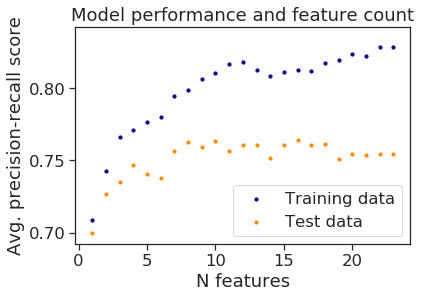

In [42]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(range(1,(len(feature_names) + 1)), train_scores, s=10, c='darkblue', label='Training data')
ax.scatter(range(1,(len(feature_names) + 1)), test_scores, s=10, c='darkorange', label='Test data')
plt.legend(loc='lower right')
plt.title("Model performance and feature count")
plt.xlabel("N features")
plt.ylabel("Avg. precision-recall score")
plt.show()

**Average precision-recall score, training set: 0.78**

**Average precision-recall score, test set: 0.74**

Raw count confusion matrix
[[209  91]
 [ 58 242]]


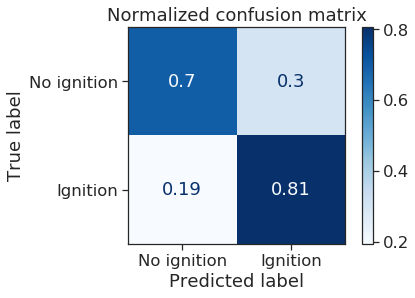

In [47]:
# grab top n feature names
top_n_features = feature_names[indices[0:6]]

# rebuild training and test sets with feature subset
balanced_data_subset = balanced_data[top_n_features]
x_train_balanced_subset, y_train_balanced_subset, x_test_balanced_subset, y_test_balanced_subset = stratified_train_test_split(balanced_data_subset, balanced_targets, rand_seed)

# instantiate and train classifier with optimized hyperparameters
xgb_mod = XGBClassifier(
        n_jobs=(xgb_jobs * optimization_jobs), # use everything we've got! 
        random_state=rand_seed
)

xgb_mod.fit(x_train_balanced_subset, y_train_balanced_subset)

# score and show confusion matrix
print_model_score(xgb_mod, x_train_balanced_subset, y_train_balanced_subset, x_test_balanced_subset, y_test_balanced_subset)
display_confusion_matrix(xgb_mod, class_names, x_test_balanced_subset, y_test_balanced_subset)

In [49]:
top_n_features

array(['ulwrf.sfc', 'veg', 'weather_bin_month', 'lcdc', 'dswrf', 'air.2m'],
      dtype='<U17')

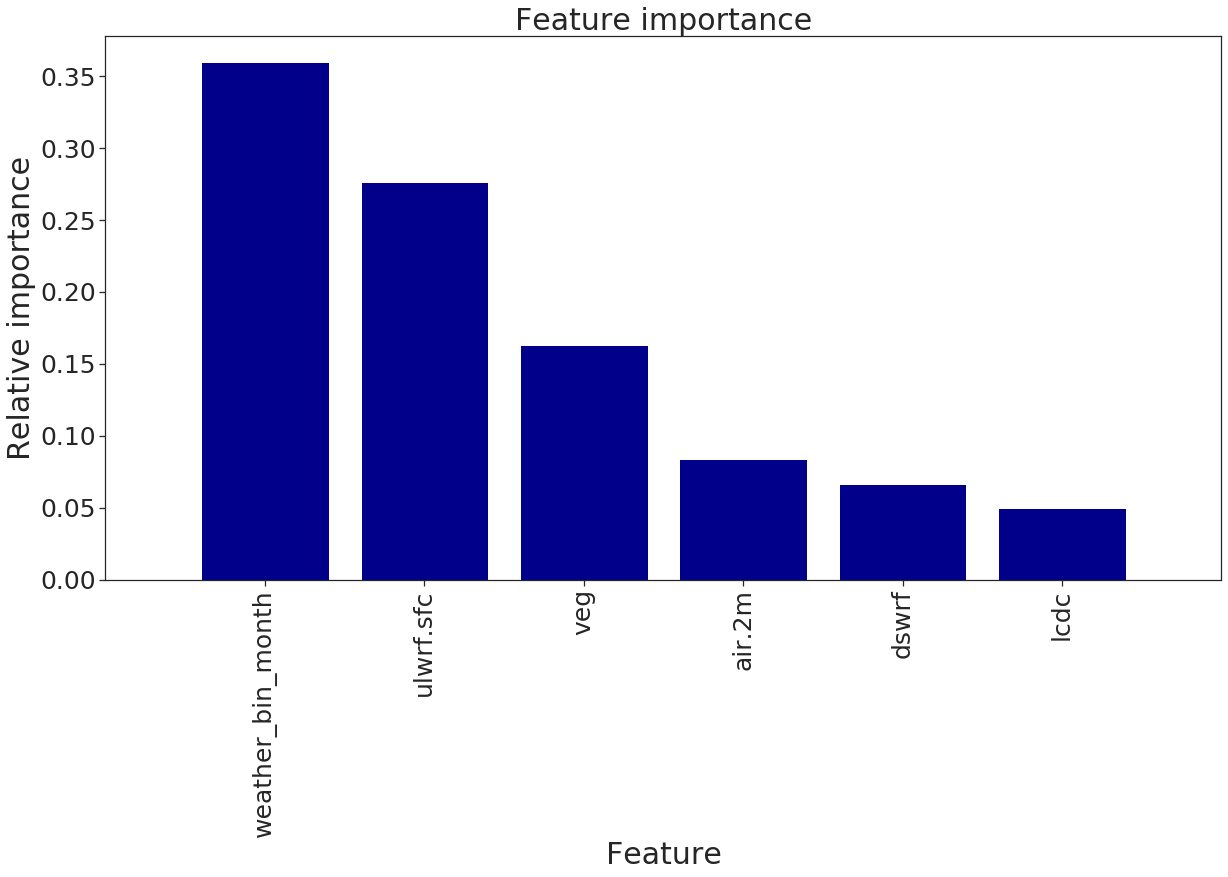

In [50]:
importances = xgb_mod.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = top_n_features

plt.figure(figsize=(20,10))
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.title("Feature importance")
plt.bar(range(x_test_balanced_subset.shape[1]), importances[indices],
       color="darkblue", align="center")
plt.xticks(np.arange(len(indices)), feature_names[indices], rotation='vertical')
plt.xlim([-1, x_test_balanced_subset.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Relative importance")
plt.show()

In [52]:
from random import randint

train_scores = list()
test_scores = list()
false_neg_rates = list()
false_pos_rates = list()

# grab top n feature names
top_n_features = feature_names[indices[0:6]]
unbalanced_data_subset = unbalanced_data[top_n_features]

for i in range(0, 1000):

    # rebuild training and test sets with feature subset
    # note: we are passing a different pesudorandom seed each
    # time so we should end up with different samples
    x_train_stratified_subset, y_train_stratified_subset, x_test_stratified_subset, y_test_stratified_subset = stratified_train_test_split(unbalanced_data_subset, unbalanced_targets, randint(0, 1e5))

    # instantiate and train classifier with optimized hyperparameters
    xgb_mod = XGBClassifier(
        n_jobs=(xgb_jobs * optimization_jobs), # use everything we've got! 
        random_state=rand_seed
    )

    xgb_mod.fit(x_train_stratified_subset, y_train_stratified_subset)
    predicted_y = xgb_mod.predict(x_test_stratified_subset)
    
    training_score = average_precision_score(xgb_mod.predict(x_train_stratified_subset), y_train_stratified_subset)
    test_score = average_precision_score(predicted_y, y_test_stratified_subset)

    train_scores.append(training_score)
    test_scores.append(test_score)
    
    cm = confusion_matrix(y_test_stratified_subset, predicted_y)
    
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]

    false_neg_rates.append(FN / (FN + TN))
    false_pos_rates.append(FP / (FP + TN))

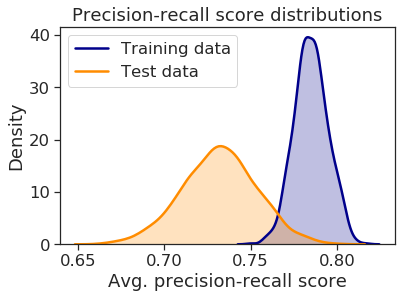

In [54]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

ax = sns.kdeplot(train_scores, label="Training data", shade=True, color="darkblue")
ax = sns.kdeplot(test_scores, label="Test data", shade=True, color="darkorange")
ax.set_title("Precision-recall score distributions")
ax.set(xlabel='Avg. precision-recall score', ylabel='Density')
plt.legend()

plt.show()

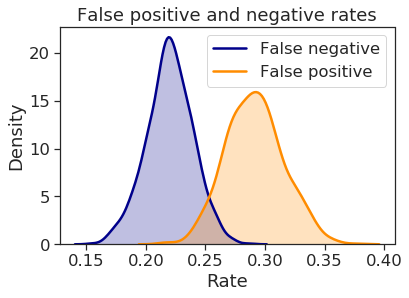

In [55]:
ax = sns.kdeplot(false_neg_rates, label="False negative", shade=True, color="darkblue")
ax = sns.kdeplot(false_pos_rates, label="False positive", shade=True, color="darkorange")
ax.set_title("False positive and negative rates")
ax.set(xlabel='Rate', ylabel='Density')
plt.legend()

plt.show()

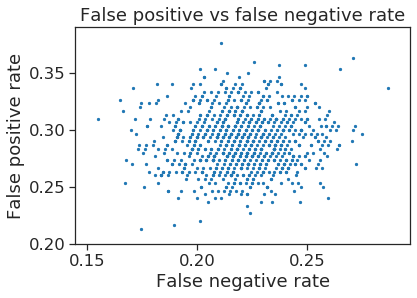

In [56]:
plt.scatter(false_neg_rates, false_pos_rates, s=5)
plt.xlabel("False negative rate")
plt.ylabel("False positive rate")
plt.title("False positive vs false negative rate")

plt.show()